This notebook will be used to compare the tidal ellipses from the model outputs to the ones generated by Mike Foreman's model in Foreman et al. (2004).

In [49]:
import os
import glob
import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex
import datetime
import pandas as pd
import subprocess as sp
from subprocess import Popen, PIPE

import netCDF4 as nc
from scipy.optimize import curve_fit
import scipy.io as sio
from salishsea_tools import (viz_tools, tidetools, nc_tools)
from salishsea_tools.nowcast import (research_VENUS, analyze)

%matplotlib inline

In [9]:
grid_B = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lats = grid_B.variables['nav_lat'][:]
lons = grid_B.variables['nav_lon'][:]
bathy = grid_B.variables['Bathymetry'][:,:]

##Loading Data
7 months of data takes a long time to compile therefore the paramters have been saved into files in this [notebook](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/analysis/raw/tip/Muriel/SaveTidalParameters.ipynb). In the cells below we will load the ellipse parameters into a matrix with all the M2 and K1 parameters at Haro Strait, Juan de Fuca West and Eastm Johnstone Strait and at Arran Rapids.

In [10]:
to = datetime.datetime(2014,11,26)
tf = datetime.datetime(2015, 6, 29)

t_o = to.strftime('%d%b%y').lower()
t_f = tf.strftime('%d%b%y').lower()

loc = ['JuanW', 'JuanE', 'Haro','SN','AR', 'JS']
count = np.arange(0,6)
params = np.zeros((6,39,5))
params_av = np.zeros((6,8))
cols=np.arange(0,5)

for i,j in zip(loc,count):
    runname1 = '{}_{}_{}'.format(t_o, t_f, i)
    runname2 = '{}_{}_{}_depav(0-400)'.format(t_o, t_f, i)
    df1 = pd.read_csv('TidalEllipseData/ForemanLocation/'+runname1+'.csv', usecols=cols) 
    df2 = pd.read_csv('TidalEllipseData/ForemanLocation/'+runname2+'.csv', index_col=False)
    params[j,:,:] = df1.as_matrix()
    params_av[j,:] = df2.as_matrix()


##The Foreman Locations

In [11]:
#Haro Strait
iH = 233
jH = 312

#Juan de Fuca West
iJW=8
jJW=408

lat33 = 48.483
lon33 = -124.713

print lats[jJW,iJW],lons[jJW, iJW]

#Juan de Fuca East
iJE = 151
jJE = 275

#Seymour Narrows -- NOTE = Modified location to enable the tidal ellipse analysis
iSN = 119
jSN = 772

#Arran Rapids -- NOTE = Modified location to enable the tidal ellipse analysis
iAR = 191
jAR = 813

#Johnstone Strait
iJS = 58
jJS = 885


48.4818878174 -124.714324951


(898, 398)
red is clockwise


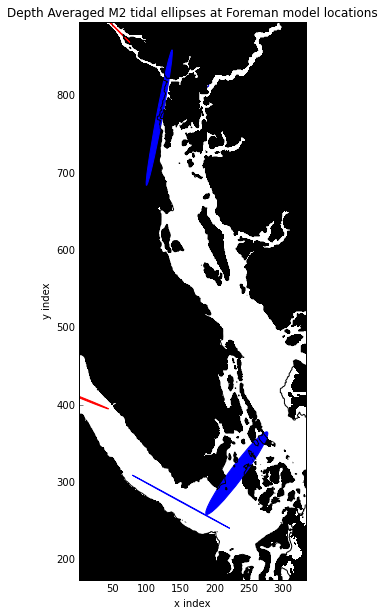

In [45]:
phi=0
fig = plt.figure(figsize=(10,10))
k = np.zeros((898,398)); m = np.zeros((898,398))
ax = fig.add_subplot(111)
viz_tools.set_aspect(ax) 
ex = 2

imin=3
imax = 333

jmin = 176
jmax = 895

for q in np.arange(jmin-ex,jmax+ex):
    for l in np.arange(imin-ex,imax+ex):
        k[q,l] = q*np.cos(phi*np.pi/180.)+l*np.sin(phi*np.pi/180.)
        m[q,l] = -q*np.sin(phi*np.pi/180.)+l*np.cos(phi*np.pi/180.) 
scale = 200

#Making the ellipse for the Central node

count = np.arange(0,6)
i = (iJW, iJE, iH, iSN, iAR, iJS)
j = (jJW, jJE, jH, jSN, jAR, jJS)

for loc, x, y in zip(count, i ,j):
    if params_av[loc,1] > 0:
        thec = 'b'
    else:
        thec = 'r'
    ellsc = Ellipse(xy=(m[y,x],k[y,x]), width=scale*params_av[loc,0], 
                        height=scale*params_av[loc,1], angle=params_av[loc,2]-29,
                        color=thec)
    ax.add_artist(ellsc)
    ellsc.set_facecolor(thec)

# y-axis in k, but labelled in latitude

ax.set_ylabel('y index')
ax.set_xlabel('x index')
print bathy.data.shape

# land, and 5 m contour
contour_interval = [-0.01, 0.01]
ax.contourf(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
        bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],contour_interval,colors='black')
ax.contour(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
            bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],[5],colors='black')
ax.set_title('Depth Averaged M2 tidal ellipses at Foreman model locations')

print "red is clockwise"

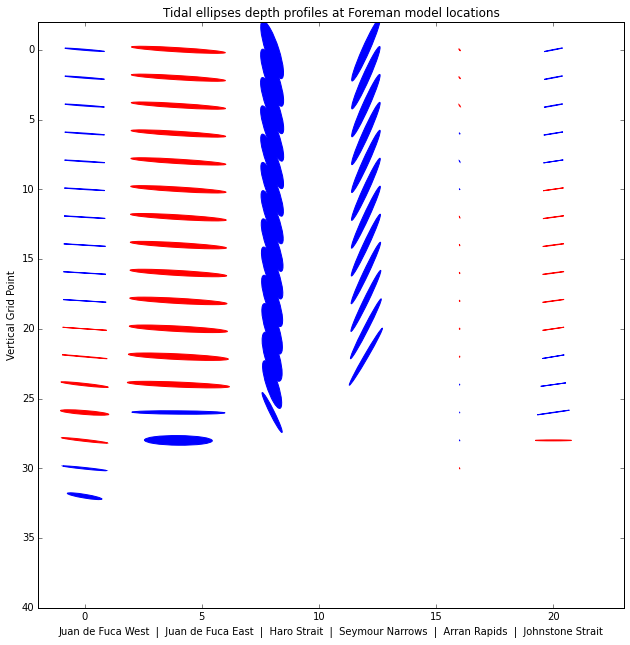

In [46]:
fig = plt.figure(figsize=(10.5,10.5))
ax = fig.add_subplot(111)
scale = 5
interval = 2

for loc in np.arange(0,6):
    for dep in np.arange(0,40,interval):
        if params[loc,dep,2] > 0:
            thec = 'b'
        else:
            thec = 'r'
        ells = Ellipse(xy=(loc*4,dep), width=scale*params[loc,dep,1], 
                            height=scale*params[loc,dep,2], angle=params[loc,dep,3],
                            color=thec)
        ax.add_artist(ells)
        ells.set_facecolor(thec)

ax.set_ylim(-2,40)
ax.invert_yaxis()
ax.set_xlim(-2,23)
ax.set_title('Tidal ellipses depth profiles at Foreman model locations')
ax.set_ylabel('Vertical Grid Point')
ax.set_xlabel('Juan de Fuca West  |  Juan de Fuca East  |  Haro Strait  |  Seymour Narrows  |  Arran Rapids  |  Johnstone Strait')

Some of the rivers and channels around Arran Rapids are unresolvable by our model. Therefore the water flow is not as intense as it should be.

##Load Foreman Model Values from MATLAB
The u and v velocities were calculated from Mike Foreman's model using MATLAB code written by Richard Dewey.
I used the same period of time as for the model output parameters, but these value have one u and v for each day, the Salish Sea MEOPAR model uses hourly data.

In [47]:
lon = lons[j,i]
lat = lats[j,i]
print lat, lon

[ 48.48188782  48.2318306   48.53623581  50.12592697  50.41913986
  50.45459366] [-124.71432495 -123.52949524 -123.22576141 -125.35070038 -125.10941315
 -126.04235077]


In [53]:
param_mat = np.zeros((6,4))
os.chdir(r'/ocean/mdunn/Tides/')
for k in count:
    p = Popen(["matlab","-nodesktop","-nodisplay","-r", "findparam(%s,%s)" % (lon[k], lat[k])], stdout=PIPE, stderr=PIPE)
    output, err = p.communicate()
    param_mat[k] = np.loadtxt('output.txt')

In [54]:
loc = ['Juan de Fuca West','Juan de Fuca East','Haro Strait','Seymour Narrows', 'Arran Rapids','Johnstone Strait ']
k = np.arange(0,6)
obs_amp = [0.389, 0.735, 0.513, 4.661, 4.564, 0.381]
obs_pha = [294, 304, 312, 113, 267, 88]
foreman2004 = [0.502, 0.932, 0.601, 3.736, 6.292, 0.652]

##Comparison with a table
Using the depth averaged (20-200m) of the Salish Sea MEOPAR model to compare with Foremans Model's parameters calculated two different ways

    Foreman Model: Modified Dewey's code to output the tidal ellipse parameters of the given locations directly.
    
    Obs Amp: Is the reported observational data from Foreman et al. (2004)
    
    Foreman et al. (2004): Is the modelled amplitude reported in the 2004 paper, and the observational value reported in that paper

In [56]:
print "                       Foreman Model         |   Foreman et al.(2004)  |   Salish Sea Model"
print "              Major-Axis Minor-Axis   Angle  | Amp(obs)     Amp(model) | Major-Axis  Minor-Axis   Angle"
print "                 (m/s)    (m/s)   (deg ccw E)|    (m/s)       (m/s)    |   (m/s)       (m/s)   (deg ccw E)" 

for name, i in zip(loc, k):
        print '%-20s {0:.2f}    {1:5.2f}    {2:3.0f}         {3:.2f}         {4:.2f}       {5:5.2f}       {6:5.2f}       {7:3.0f}'.format( 
               param_mat[i,0], param_mat[i,1], param_mat[i,2], obs_amp[i], foreman2004[i],params_av[i,0], params_av[i,1], params_av[i,2]) %name

                       Foreman Model         |   Foreman et al.(2004)  |   Salish Sea Model
              Major-Axis Minor-Axis   Angle  | Amp(obs)     Amp(model) | Major-Axis  Minor-Axis   Angle
                 (m/s)    (m/s)   (deg ccw E)|    (m/s)       (m/s)    |   (m/s)       (m/s)   (deg ccw E)
Juan de Fuca West    0.51    -0.00     56         0.39         0.50        0.39       -0.01        10
Juan de Fuca East    0.93     0.01      3         0.73         0.93        0.79        0.00         3
Haro Strait          0.68    -0.06     98         0.51         0.60        0.70        0.10        79
Seymour Narrows      2.06    -0.15    126         4.66         3.74        0.90        0.04       107
Arran Rapids         0.13    -0.02    161         4.56         6.29        0.01        0.00        82
Johnstone Strait     0.78    -0.07    155         0.38         0.65        0.24       -0.00       167


The Salish Sea MEOPAR Model is closest to the observations reported in Foreman et al. (2004) observation for the three first locations!

##Modifications at Juan de Fuca West

The Juan de Fuca West location is in the 3rd grid point from the edge of the domain. It's speed and direction is completely governed by the boundary conditions. However in the comparisons below we will be comparing it to the Foreman model values which has the Juan de Fuca West location as part of the open ocean almost.
The inclination changes drastically (from 56 to 3 degres) when I choose to only use the closest node of the Foreman model but the other parameters maintain relatively constant.
I will change the inclination of the Foreman model to the value when it is just evaluating the parameters at the closest node because I think then I will be comparing the same things below.

In [60]:
param_mat[0,2] = 3

##Graph Comparison

In [61]:
count = np.arange(0,6)
parameter = ['major-axis','major-axis (zoom)', 'minor-axis', 'inclination']
unit = ['m/s', 'm/s' ,'m/s','deg']

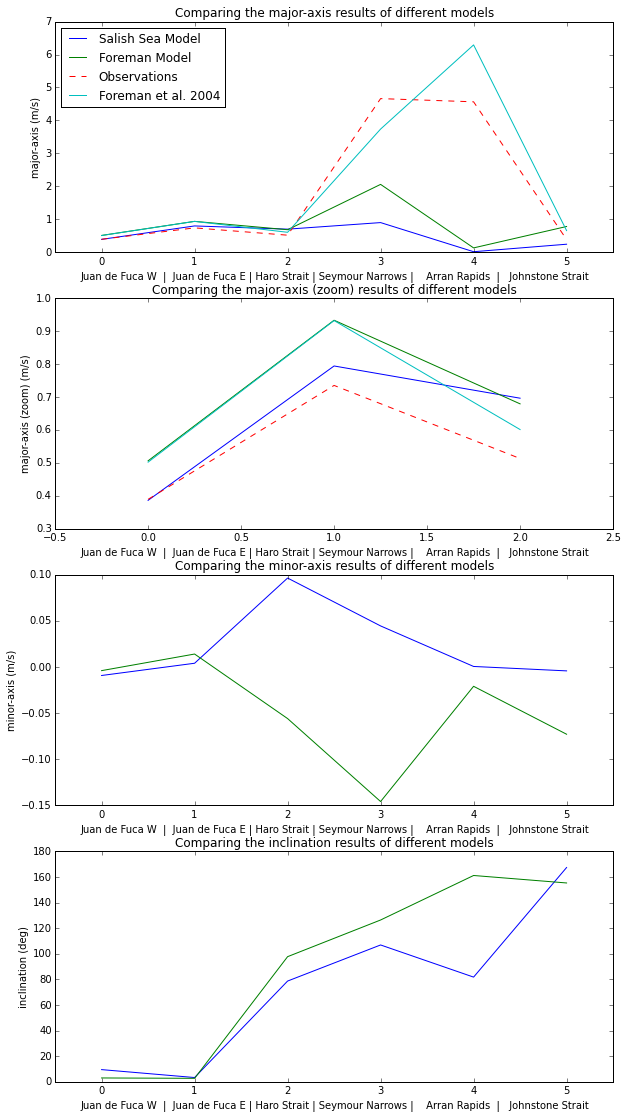

In [62]:
fig, (ax0, ax1, ax2, ax3)= plt.subplots(4,1,figsize=(10,19))

for ax , k, par, u in zip([ax0, ax1, ax2, ax3], [0,0,1,2], parameter, unit):
    if ax == ax1:
        ax.plot(count[:-3],params_av[:-3,k], '-', label='Salish Sea Model')
        ax.plot(count[:-3], param_mat[:-3,k], '-', label='Foreman Model') 
        ax.plot(count[:-3], obs_amp[:-3], '--',label='Observations')
        ax.plot(count[:-3], foreman2004[:-3], '-',label='Foreman et al. 2004')
        ax.set_xlim([-0.5,2.5])
        
    elif ax == ax0:
        
        ax.plot(count[:],params_av[:,k], '-', label='Salish Sea Model')
        ax.plot(count[:], param_mat[:,k], '-', label='Foreman Model')
        ax.plot(count[:], obs_amp[:], '--',label='Observations')
        ax.plot(count[:], foreman2004[:], '-',label='Foreman et al. 2004')
        ax.legend(loc = 2)
        ax.set_xlim([-0.5, 5.5])
    else:
        ax.plot(count[:],params_av[:,k], '-', label='Salish Sea Model')
        ax.plot(count[:], param_mat[:,k], '-', label='Foreman Model')
        ax.set_xlim([-0.5, 5.5])

    ax.set_title('Comparing the {} results of different models'.format(par))
    ax.set_xlabel('Juan de Fuca W  |  Juan de Fuca E | Haro Strait | Seymour Narrows |    Arran Rapids  |   Johnstone Strait')
    ax.set_ylabel('{} ({})'.format(par,u))

##Map comparison

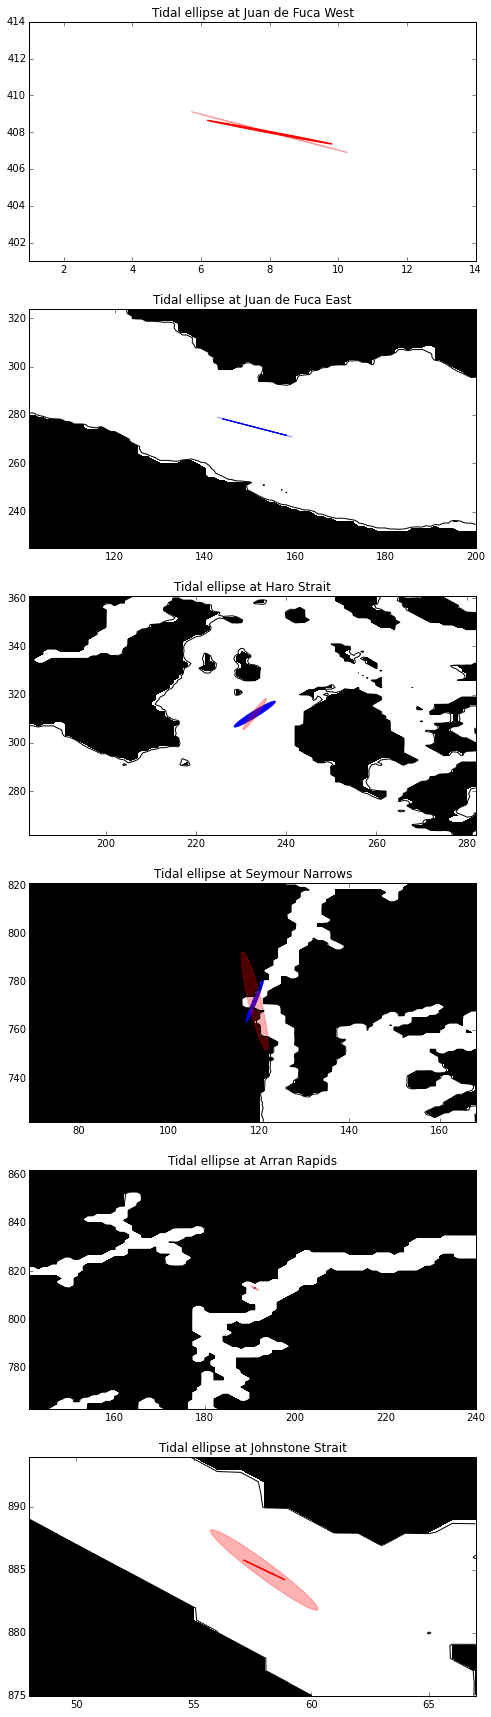

In [44]:
phi=0
fig, ax = plt.subplots(6 , 1, figsize=(8,30))
k = np.zeros((898,398))
m = np.zeros((898,398))


count = np.arange(0,6)
name = ['Juan de Fuca West','Juan de Fuca East', 'Haro Strait','Seymour Narrows', 'Arran Rapids', 'Johnstone Strait']
iss = [iJW, iJE, iH, iSN, iAR, iJS]
jss = [jJW, jJE, jH, jSN, jAR, jJS]

for a, b, c, n in zip(iss, jss, count, name): 
    if b > 850:
        ex = 10
        scale = 10
    elif a < 10:
        ex = 7
        scale = 10
    else:
        ex = 50
        scale = 20

    imin = a
    imax = a

    jmin = b
    jmax = b

    for q in np.arange(jmin-ex,jmax+ex):
        for l in np.arange(imin-ex,imax+ex):
            k[q,l] = q*np.cos(phi*np.pi/180.)+l*np.sin(phi*np.pi/180.)
            m[q,l] = -q*np.sin(phi*np.pi/180.)+l*np.cos(phi*np.pi/180.) 
    

    #Making the ellipse Salish Sea Model
    if params_av[c,1] > 0:
         thec = 'b' 
    else:
         thec = 'r'
    ellsc1 = Ellipse(xy=(m[b,a],k[b,a]), width=scale*params_av[c,0], 
                            height=scale*params_av[c,1], angle=params_av[c,2]-29,
                            color=thec)
    ax[c].add_artist(ellsc1)
    ellsc1.set_facecolor(thec)

    #Making the ellipse Foreman model
    if param_mat[c,1] > 0:
        thec = [0,0,1, 0.3]
    else:
        thec = [1,0,0, 0.3]
    ellsc = Ellipse(xy=(m[b,a],k[b,a]), width=scale*param_mat[c,0], 
                            height=scale*param_mat[c,1], angle=param_mat[c,2]-29,
                            color=thec)
    ax[c].add_artist(ellsc)
    ellsc.set_facecolor(thec)
    # land, and 5 m contour
    contour_interval = [-0.01, 0.01]
    ax[c].contourf(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
            bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],contour_interval,colors='black')
    ax[c].contour(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
                bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],[5],colors='black')
    ax[c].set_title('Tidal ellipse at {}'.format(n))
